In [1]:
library('msm')
library(ggplot2)
library(sandwich)
library(msm)

### Examples of Poisson regression

### Description of the data

In [2]:
p <- read.csv("./datasets/poisson_sim.csv")
p <- within(p, {
     prog <- factor(prog, levels=1:3, labels=c("General", "Academic", "Vocational"))
     id <- factor(id)})
summary(p)

       id        num_awards           prog          math      
 1      :  1   Min.   :0.00   General   : 45   Min.   :33.00  
 2      :  1   1st Qu.:0.00   Academic  :105   1st Qu.:45.00  
 3      :  1   Median :0.00   Vocational: 50   Median :52.00  
 4      :  1   Mean   :0.63                    Mean   :52.65  
 5      :  1   3rd Qu.:1.00                    3rd Qu.:59.00  
 6      :  1   Max.   :6.00                    Max.   :75.00  
 (Other):194                                                  

In [3]:
with(p, tapply(num_awards, prog, function(x) {
    sprintf("M (SD) = %1.2f (%1.2f)", mean(x), sd(x))}))

General               Academic             Vocational 
"M (SD) = 0.20 (0.40)" "M (SD) = 1.00 (1.28)" "M (SD) = 0.24 (0.52)"

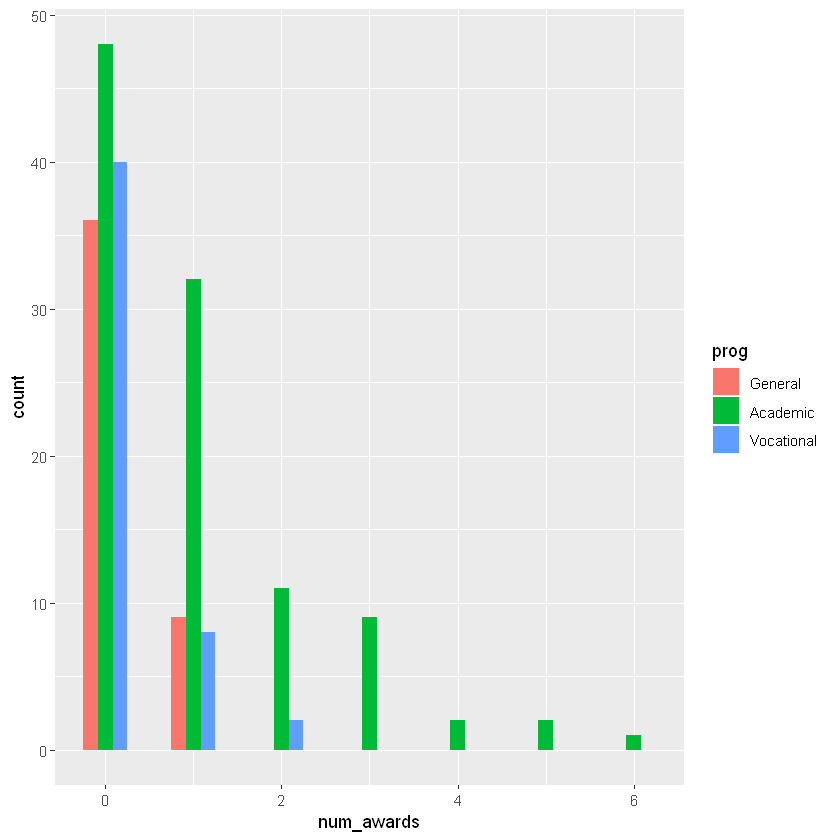

In [4]:
ggplot(p, aes(num_awards, fill = prog)) +
    geom_histogram(binwidth=.5, position="dodge")

### Analysis methods you might consider

### Poisson regression

In [5]:
summary(m1 <- glm(num_awards ~ prog + math, family="poisson", data=p))


Call:
glm(formula = num_awards ~ prog + math, family = "poisson", data = p)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2043  -0.8436  -0.5106   0.2558   2.6796  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -5.24712    0.65845  -7.969 1.60e-15 ***
progAcademic    1.08386    0.35825   3.025  0.00248 ** 
progVocational  0.36981    0.44107   0.838  0.40179    
math            0.07015    0.01060   6.619 3.63e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 287.67  on 199  degrees of freedom
Residual deviance: 189.45  on 196  degrees of freedom
AIC: 373.5

Number of Fisher Scoring iterations: 6


In [6]:
cov.m1 <- vcovHC(m1, type="HC0")
std.err <- sqrt(diag(cov.m1))
r.est <- cbind(Estimate= coef(m1), "Robust SE" = std.err,
         "Pr(>|z|)" = 2 * pnorm(abs(coef(m1)/std.err), lower.tail=FALSE),
         LL = coef(m1) - 1.96 * std.err,
         UL = coef(m1) + 1.96 * std.err)
r.est

,Estimate,Robust SE,Pr(>|z|),LL,UL
(Intercept),-5.2471244,0.64599839,4.566630e-16,-6.51328124,-3.98096756
progAcademic,1.0838591,0.32104816,7.354745e-04,0.45460476,1.71311353
progVocational,0.3698092,0.40041731,3.557157e-01,-0.41500870,1.15462716
math,0.0701524,0.01043516,1.783975e-11,0.04969947,0.09060532


In [7]:
with(m1, cbind(res.deviance = deviance, df = df.residual,
    p = pchisq(deviance, df.residual, lower.tail=FALSE)))

res.deviance,df,p
189.4496,196,0.6182274


In [8]:
## update m1 model dropping prog
m2 <- update(m1, . ~ . - prog)

## test model differences with chi square test
anova(m2, m1, test="Chisq")

Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
198,204.0213,NA,NA,NA
196,189.4496,2,14.57168,0.0006851718


In [9]:
s <- deltamethod(list(~ exp(x1), ~ exp(x2), ~ exp(x3), ~ exp(x4)), coef(m1), cov.m1)

## exponentiate old estimates dropping the p values
rexp.est <- exp(r.est[, -3])

## replace SEs with estimates for exponentiated coefficients
rexp.est[, "Robust SE"] <- s
rexp.est

,Estimate,Robust SE,LL,UL
(Intercept),0.00526263,0.00339965,0.001483604,0.01866757
progAcademic,2.95606545,0.94903937,1.575550534,5.54620292
progVocational,1.44745846,0.57958742,0.660334536,3.17284023
math,1.07267164,0.01119351,1.050955210,1.09483681


In [10]:
(s1 <- data.frame(math = mean(p$math),
    prog = factor(1:3, levels = 1:3, labels = levels(p$prog))))

math,prog
52.645,General
52.645,Academic
52.645,Vocational


In [11]:
predict(m1, s1, type="response", se.fit=TRUE)

$fit
        1         2         3 
0.2114109 0.6249446 0.3060086 

$se.fit
         1          2          3 
0.07050108 0.08628117 0.08833706 

$residual.scale
[1] 1

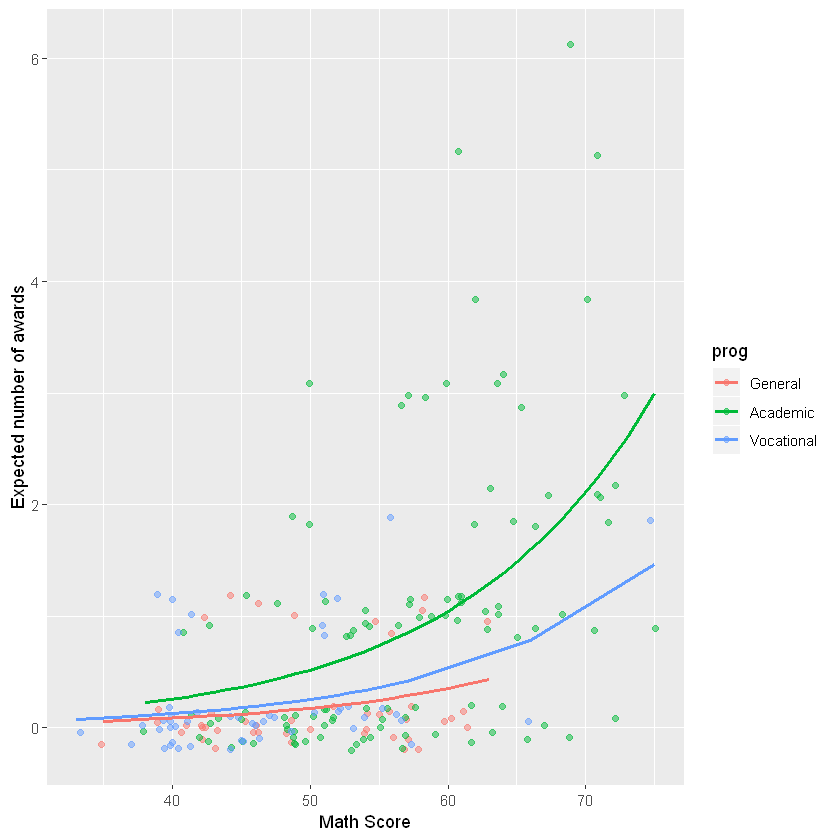

In [12]:
## calculate and store predicted values
p$phat <- predict(m1, type="response")

## order by program and then by math
p <- p[with(p, order(prog, math)), ]

## create the plot
ggplot(p, aes(x = math, y = phat, colour = prog)) +
    geom_point(aes(y = num_awards), alpha=.5, position=position_jitter(h=.2)) + 
    geom_line(size = 1) + labs(x = "Math Score", y = "Expected number of awards")

### Things to consider